#  HARPS-GTO и возраст звёзд

## Мотивация

В предыдущих частях этого практикума мы сформировали надёжную наблюдательную картину Галактического диска:
- охарактеризовали современную радиальную структуру металличности с использованием данных APOGEE × Gaia,
- ввели возраста звёзд на основе астеросейсмически откалиброванных выборок APOGEE,
- показали, что металличностные структуры эволюционируют со временем и радиусом.

Однако звёзды не обязаны оставаться на том галактоцентрическом радиусе, где они родились.
Радиальная миграция перераспределяет звёзды на протяжении миллиардов лет, размывая связь между текущим положением и условиями формирования.

Поэтому центральная мотивация ACAP_003 заключается в следующем:

**восстановить галактоцентрические радиусы рождения звёзд на основе наблюдаемых возрастов и металличностей, используя эмпирические тренды галактической химической эволюции как приближение для межзвёздной среды (`ISM`).**

Этот шаг позволяет перейти от описательной к реконструктивной галактической археологии.

## Научная идея

Ключевое физическое предположение, лежащее в основе этого упражнения, является простым и прозрачным:
- В каждый момент времени металличность ISM систематически зависела от галактоцентрического радиуса.
- Звёзды наследуют металличность ISM в момент и месте своего рождения.
- Если известны возраст и металличность звезды, а также эмпирическая модель эволюции металличности ISM, можно оценить, где эта звезда с наибольшей вероятностью сформировалась.

В этом практикуме мы намеренно избегаем полноценного хемо-динамического моделирования и вместо этого опираемся на:
- наблюдательно откалиброванные тренды,
- минимальные параметрические аппроксимации,
- явный контроль и распространение неопределённостей.

## Структура практикума

ACAP_003 организован как пошаговый реконструктивный пайплайн:
1.	Подготовка звёздных выборок с возрастами, металличностями и информацией о планетах.
2.	Задание эмпирической, зависящей от времени модели металличности ISM.
3.	Инверсия этой модели для оценки радиусов рождения звёзд.
4.	Анализ распределения звёзд-хостов планет в реконструированном Галактическом диске.
5.	Сравнение различных звёздных популяций (одиночные звёзды, хосты планет, планеты высокой/низкой массы).

Каждому шагу соответствует небольшое число чётко подписанных ячеек ноутбука.

## Пайплайн предобработки данных

![Пайплайн данных для ACAP 003](../assets/ACAP_003_EN_Data_Pipeline.png)

----

## Настройка ноутбука: пути и экспорт рисунков

### Назначение этой ячейки

Эта ячейка выполняет базовую инициализацию ноутбука и определяет небольшую вспомогательную утилиту, которая будет использоваться на протяжении всего практикума.

Её роль носит исключительно инфраструктурный характер: на этом этапе ещё не выполняются научные вычисления или визуализации.


В частности, эта ячейка:
1.	Определяет корневую директорию проекта
Ноутбук может запускаться из разных подкаталогов.

Чтобы все пути были устойчивыми и воспроизводимыми, мы автоматически поднимаемся вверх по дереву каталогов до тех пор, пока не найдём папку topics, которая служит маркером корня проекта.

2.	Задаёт рабочую директорию для данного практикума
Все результаты, относящиеся к этому практикуму (рисунки, анимации, наборы данных), сохраняются в каталоге
`topics/TOP_0001_exoplanet_birth_radius`.

3.	Создаёт выделенную директорию для экспортируемых рисунков
Все рисунки, сгенерированные в этом ноутбуке, сохраняются в языко-зависимую папку
(`figures/ru`), что упрощает последующую компоновку PDF-документов или повторное использование результатов в других продуктах.

4.	Определяет вспомогательную функцию `save_fig()`, которая стандартизирует процесс сохранения рисунков:
- единный формат файлов (`PNG`),
- единное разрешение (`DPI`),
- единный режим компоновки (`bbox_inches="tight"`),
- и одно предсказуемое место сохранения.

Использование такой вспомогательной функции избавляет от повторяющегося шаблонного кода и гарантирует, что все рисунки в ноутбуке экспортируются единообразно.

Такая настройка позволяет в последующих ячейках сосредоточиться на научных идеях и интерпретации результатов, не отвлекаясь на работу с путями и управлением файлами.

In [1]:
# =========================================================
# Cell 0 — Universal bootstrap (globals, paths, theme, i18n)
# Works for: ACAP_* and ANIM_*
# =========================================================

from __future__ import annotations

from pathlib import Path
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lulab.io.paths import (
    get_topic_root,
    figures_dir,
    data_raw_dir,
    data_processed_dir,
    animations_dir,
)
from lulab.io.save_figure import save_fig
import lulab.io.theme as th

# -----------------------------
# External services (Vizier)
# -----------------------------
from astroquery.vizier import Vizier

# No row limit by default
Vizier.ROW_LIMIT = -1

from tqdm import tqdm

# -----------------------------
# Global notebook constants
# -----------------------------
TOPIC: str = "TOP_0001_exoplanet_birth_radius"
NOTEBOOK: str = "ACAP_003"   # e.g. "ACAP_001", "ANIM_001"
LANG: str = "ru"             # "en" / "ru"
THEME: str = "light"          # "light" / "dark"

# -----------------------------
# Animation export settings (safe to keep for ACAP too)
# -----------------------------
ANIM_FORMAT = "mp4"       # "gif" / "mp4"
FPS = 24
DPI = 200

MP4_CODEC = "libx264"
MP4_BITRATE = 1800

GIF_WRITER = "pillow"
GIF_LOOP = 0

# --- physical limits (keep consistent) ---
AGE_MIN_GYR = 0.1
AGE_MAX_GYR = 13.5
R_SUN = 8.0  # kpc

# -----------------------------
# Common paths
# -----------------------------
TOPIC_ROOT: Path = get_topic_root(TOPIC)
FIG_DIR: Path = figures_dir(TOPIC, lang=LANG, create=True)

DATA_RAW_DIR: Path = data_raw_dir(TOPIC, create=False)
DATA_PROCESSED_DIR: Path = data_processed_dir(TOPIC, create=True)

ANIM_DIR: Path = animations_dir(TOPIC, create=True)

# --- legacy aliases (do NOT remove, used in older cells) ---
RAW  = DATA_RAW_DIR
PROC = DATA_PROCESSED_DIR

# -----------------------------
# Theme
# -----------------------------
# Use a single consistent entry point everywhere
th.apply_theme(THEME)

# -----------------------------
# Save helpers
# -----------------------------
def save_fig0(fig_id: str, *, fig):
    """
    Save figure with notebook-scoped ID to avoid collisions.

    Example:
        save_fig0("Figure_3", fig=fig)
    -> build artifact ID:
        ANIM_001_Figure_3
    """
    full_id = f"{NOTEBOOK}_{fig_id}"
    return save_fig(full_id, fig=fig, topic=TOPIC, lang=LANG)

def anim_outpath(anim_id: str, ext: str | None = None) -> Path:
    """
    Standard output path for animations.
    Example:
        out = anim_outpath("Orbit_1")  -> ANIM_DIR/ANIM_001_Orbit_1.mp4
        out = anim_outpath("Orbit_1", ext="gif")
    """
    if ext is None:
        ext = ANIM_FORMAT
    return ANIM_DIR / f"{NOTEBOOK}_{anim_id}.{ext}"

# -----------------------------
# i18n bootstrap (force reload to avoid stale imports)
# -----------------------------
import lulab.i18n.plot_text as pt
importlib.reload(pt)

pt.set_lang(LANG)
if hasattr(pt, "set_notebook"):
    pt.set_notebook(NOTEBOOK)

pt.load_topic_i18n(TOPIC_ROOT, strict=True)

# convenience aliases (stable)
L = pt.L
T = pt.T

# -----------------------------
# Quick sanity printout
# -----------------------------
print("\n--- BOOTSTRAP ---")
print("TOPIC      :", TOPIC)
print("NOTEBOOK   :", NOTEBOOK)
print("LANG       :", LANG)
print("THEME      :", THEME)
print("TOPIC_ROOT :", TOPIC_ROOT)
print("FIG_DIR    :", FIG_DIR)
print("DATA_RAW   :", DATA_RAW_DIR)
print("DATA_PROC  :", DATA_PROCESSED_DIR)
print("ANIM_DIR   :", ANIM_DIR)
print("ANIM_FORMAT:", ANIM_FORMAT)
print("FPS / DPI  :", FPS, "/", DPI)


--- BOOTSTRAP ---
TOPIC      : TOP_0001_exoplanet_birth_radius
NOTEBOOK   : ACAP_003
LANG       : ru
THEME      : light
TOPIC_ROOT : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius
FIG_DIR    : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/ru
DATA_RAW   : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/raw
DATA_PROC  : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed
ANIM_DIR   : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations
ANIM_FORMAT: mp4
FPS / DPI  : 24 / 200


----

## Ячейка 1. Загрузка и очистка выборки SWEET-Cat

### Назначение ячейки

В этой ячейке загружается и подготавливается каталог **SWEET-Cat**, который представляет собой тщательно отобранную выборку близких звёзд спектральных классов FGK с хорошо определёнными звёздными параметрами и информацией о планетах.

SWEET-Cat играет ключевую роль в данном практикуме, поскольку именно он определяет **популяцию звёзд-хостов планет**, которая впоследствии будет сопоставляться с трендами галактической химической эволюции и реконструированными радиусами рождения.

### Что делает эта ячейка

1. **Загрузка каталога SWEET-Cat**

   Каталог считывается из директории с исходными данными в формате CSV.  
   Файл содержит звёздные параметры (эффективную температуру, поверхностную гравитацию, металличность), а также метаданные для звёзд с обнаруженными планетами.

2. **Отбор высококачественной подвыборки SWEET-Cat**

   Мы оставляем только объекты с флагом `SWFlag == 1`, который указывает на:
   - однородный спектроскопический анализ,
   - надёжные звёздные параметры,
   - согласованную методику определения параметров по всему каталогу.

   Этот критерий качества гарантирует, что выборка SWEET-Cat является внутренне согласованной и пригодной для статистического анализа.

3. **Нормализация имён столбцов**

   Для удобства и единообразия при работе с разными каталогами (`HARPS`, `APOGEE`, `Gaia`) мы переименовываем ключевые столбцы звёздных параметров:
   - `Logg` → `logg`
   - `[Fe/H]` → `feh`

   Это позволяет избежать условной логики и специальных случаев в последующих ячейках.

4. **Удаление неполных записей**

   Из выборки исключаются звёзды, у которых отсутствует хотя бы один из базовых параметров:
   - эффективная температура (`Teff`),
   - поверхностная гравитация (`logg`),
   - металличность (`feh`).

### Результат

Результатом работы этой ячейки является очищенный DataFrame `sweet`, содержащий:
- высококачественную выборку звёзд с планетами,
- однородные звёздные параметры,
- согласованные имена столбцов.

Этот DataFrame служит **эталонной популяцией звёзд c планетами** на протяжении всего практикума ACAP_003 и далее используется при добавлении оценок возрастов и реконструированных галактоцентрических радиусов рождения.

In [2]:
sweet = pd.read_csv(DATA_RAW_DIR / "sweetcat.csv")
sweet = sweet[sweet["SWFlag"] == 1].copy()

# normalize column names
sweet = sweet.rename(columns={"Logg":"logg", "Teff":"Teff", "[Fe/H]":"feh"})
sweet = sweet.dropna(subset=["Teff","logg","feh"])


----

## Ячейка 2. Загрузка и очистка сравнительной выборки HARPS

### Назначение ячейки

В этой ячейке загружается опорная звёздная выборка из обзора **HARPS-GTO**, которая используется как **сравнительная популяция** по отношению к звёздам-хостам планет из каталога **SWEET-Cat**.

HARPS предоставляет большую и однородную выборку близких звёзд спектральных классов FGK с хорошо измеренными атмосферными параметрами, что делает его идеальной базой для популяционных сравнений.

### Что делает эта ячейка

1. **Загрузка каталога HARPS из VizieR**

   Таблица `J/A+A/545/A32` загружается из сервиса VizieR без ограничения на число строк, что гарантирует использование полной опубликованной выборки.

2. **Стандартизация имён столбцов**

   Столбец металличности `[Fe/H]` переименовывается в `feh` для согласованности с другими наборами данных, используемыми в практикуме.

3. **Базовая фильтрация по качеству данных**

   В выборке сохраняются только те звёзды, для которых доступны все ключевые параметры:
   - эффективная температура (`Teff`),
   - поверхностная гравитация (`logg`),
   - металличность (`feh`),
   - звёздные идентификаторы (`Star`, `SimbadName`).

### Результат

Итоговый DataFrame `harps` представляет собой очищенную и однородную **сравнительную выборку близких звёзд поля**, с которой в последующих разделах будут сопоставляться свойства звёзд-хостов планет из каталога **SWEET-Cat**.

In [3]:
Vizier.ROW_LIMIT = -1
harps = Vizier.get_catalogs("J/A+A/545/A32")[0].to_pandas()

harps = harps.rename(columns={"[Fe/H]":"feh"})
harps = harps.dropna(subset=["Teff","logg","feh","Star","SimbadName"])

---

## Ячейка 3. Загрузка каталога планет NEA и определение классов звёзд-хостов

### Назначение ячейки

В этой ячейке загружаются данные о планетных системах из **NASA Exoplanet Archive (NEA)** и каждому звёздному хосту присваивается **класс планетной системы**.
Эти классы используются далее для разделения звёзд, содержащих планеты большой и малой массы, в соответствии с логикой референсной статьи.

### Что делает эта ячейка

1. **Загрузка каталога планет NEA**

   Файл `nea_ps_default_flag_1.csv` содержит подтверждённые экзопланетные системы со стандартизированными параметрами планет и их хост-звёзд.

2. **Канонизация имён звёзд-хостов**

   Названия звёзд-хостов встречаются в разных каталогах в несогласованных форматах.
   Вспомогательная функция `canon_name()`:
   - приводит строки к нижнему регистру,
   - удаляет скобки и пробелы,
   - унифицирует различные варианты дефисов,
   - удаляет нестандартные символы.

   В результате формируется устойчивый ключ `host_key`, используемый для кросс-сопоставления с каталогами звёзд (SWEET-Cat, HARPS).

3. **Извлечение масс планет**

   Код автоматически выбирает наиболее подходящий столбец с массой планеты:
   - `pl_bmassj`, `pl_massj` — массы в юпитерианских массах,
   - `pl_masse` — массы в земных массах (с последующим переводом в массы Юпитера).

   Все массы приводятся к единой шкале — **массы Юпитера (`M_J`)**.

4. **Определение классов планетных систем**

   Каждая планета классифицируется как:
   - **HMPH** (*High-Mass Planet Host*) — хост массивной планеты,
   - **LMPH** (*Low-Mass Planet Host*) — хост маломассивной планеты,

   с использованием порогового значения по массе планеты (в текущей реализации — порядка `0.1 M_J`).

   Если у звезды обнаружено несколько планет, ей присваивается **максимальный класс**:
   наличие хотя бы одной массивной планеты относит звезду к классу **HMPH**.

### Результат

На выходе формируется словарь `host_class`, сопоставляющий каждому звёздному хосту его планетный класс (`HMPH` или `LMPH`).

Этот словарь используется в последующих ячейках для маркировки звёзд в каталогах **SWEET-Cat** и **HARPS**, что позволяет сравнивать свойства одиночных звёзд и звёзд с разными типами планетных систем.

In [4]:
import re

nea = pd.read_csv(RAW / "nea_ps_default_flag_1.csv")

def canon_name(x):
    if pd.isna(x): return ""
    s = str(x).strip().lower()
    s = s.replace("–","-").replace("—","-")
    s = re.sub(r"\(.*?\)", "", s)
    s = re.sub(r"\s+", "", s)
    s = re.sub(r"[^a-z0-9+\-]", "", s)
    return s

# host column
host_col = next(c for c in ["hostname","pl_hostname","sy_name","host_name","host"] if c in nea.columns)
nea["host_key"] = nea[host_col].map(canon_name)

# planet mass column (best-effort)
mp_col = next((c for c in ["pl_bmassj","pl_masse","pl_massj"] if c in nea.columns), None)
if mp_col is None:
    raise KeyError("NEA: не нашёл колонку массы планеты (pl_bmassj/pl_massj/pl_masse).")

# приводим к Mjup (если вдруг в Earth masses — грубо конвертим)
mp = pd.to_numeric(nea[mp_col], errors="coerce")
if "masse" in mp_col:
    mp_mj = mp / 317.8
else:
    mp_mj = mp

nea["mp_mj"] = mp_mj

# классы как в статье: high-mass vs low-mass (порог можно подстроить позже)
THRESH_MJ = 0.1  # пример: 0.1 Mj ~ 32 Mearth (порог уточним по статье при необходимости)
nea["planet_class"] = np.where(nea["mp_mj"] >= THRESH_MJ, "HMPH", "LMPH")

# по каждому хосту берём "максимальный" класс (если есть хотя бы одна HMPH -> HMPH)
host_max = (nea.dropna(subset=["host_key","planet_class"])
              .groupby("host_key")["planet_class"]
              .agg(lambda s: "HMPH" if (s=="HMPH").any() else "LMPH")
              .reset_index())

host_class = dict(zip(host_max["host_key"], host_max["planet_class"]))

---

## Ячейка 4. Сопоставление звёзд HARPS с классами звезд с планетами

### Назначение ячейки

В этой ячейке звёзды из выборки **HARPS-GTO** связываются с классификацией планетных систем, полученной из каталога NEA.
В результате каждая звезда HARPS помечается как:
- **одиночная звезда**, или
- **звезда с планетами**, дополнительно разделённая на хосты массивных и маломассивных планет.

### Что делает эта ячейка

1. **Канонизация имён звёзд HARPS**

   В каталоге HARPS звёзды могут идентифицироваться разными именами (`SimbadName`, `Star`).
   Оба поля нормализуются с помощью функции `canon_name()`, уже использованной ранее, что приводит к созданию двух канонических ключей:
   - `name1`
   - `name2`

   Такой подход повышает надёжность сопоставления с внешними каталогами.

2. **Определение звёзд-хостов планет**

   Звезда считается хостом планет, если **хотя бы одно** из её канонических имён присутствует в словаре `host_class`, построенном на основе данных NEA:

   `harps[“is_host”] = (name1 ∈ host_class) OR (name2 ∈ host_class)`

   3. **Присвоение класса планетной системы**

- По умолчанию всем звёздам присваивается класс `single`.
- Для звёзд-хостов класс берётся из `host_class`:
  - `HMPH` — хост массивных планет,
  - `LMPH` — хост маломассивных планет.
- Если класс не удалось определить по первому имени, используется резервное сопоставление по второму.

4. **Финализация классификации**

Все неопределённые значения заменяются на `single`, что гарантирует, что каждая звезда HARPS имеет однозначный класс.

### Результат

На выходе формируется обновлённый DataFrame `harps`, в котором каждая звезда:
- помечена флагом `is_host`,
- отнесена к одному из классов: `single`, `HMPH`, `LMPH`.

Этот шаг завершает формирование **сравнительной выборки HARPS**, которая далее используется для анализа возрастов, радиусов рождения и статистики планетных систем в Галактике.

In [5]:
harps["name1"] = harps["SimbadName"].map(canon_name)
harps["name2"] = harps["Star"].map(canon_name)

harps["is_host"] = harps["name1"].isin(host_class) | harps["name2"].isin(host_class)
harps["class"] = "single"
harps.loc[harps["is_host"], "class"] = harps.loc[harps["is_host"], "name1"].map(host_class)
# fallback на name2
m = harps["class"].isna() & harps["is_host"]
harps.loc[m, "class"] = harps.loc[m, "name2"].map(host_class)

harps["class"] = harps["class"].fillna("single")
harps["class"].value_counts()

single    941
HMPH      132
LMPH       38
Name: class, dtype: int64

----

## Ячейка 5. Кэширование сетки изохрон MIST

### Назначение ячейки

Эта ячейка подготавливает и кэширует **сетку моделей звёздной эволюции MIST**, которая далее используется для оценки возрастов звёзд.

Поскольку загрузка и построение сетки MIST являются вычислительно затратными операциями, мы выполняем их **один раз** и сохраняем результат локально.

### Что делает эта ячейка

1. **Проверка наличия кэшированной сетки MIST**

   Ячейка ищет файл:
   `data/processed/mist_grid_cache.parquet'

2. **Если сетка отсутствует**
- Загружается модель MIST через `isochrones.mist.MIST_Isochrone`
- Полная модельная сетка извлекается в `pandas.DataFrame`
- Сетка сохраняется в формате `Parquet` для быстрого последующего доступа

3. **Если сетка уже существует**
- Загрузка модели пропускается
- Используется ранее сохранённый кэш

### Почему это важно

- Обеспечивает **воспроизводимость**: одна и та же модельная сетка используется во всех запусках
- Повышает **производительность**: исключает повторные загрузки и парсинг моделей
- Чётко разделяет **звёздные модели** и обработку наблюдательных данных

Эта кэшированная сетка далее комбинируется с наблюдаемыми параметрами звёзд  
($T_\mathrm{eff}$, $\log g$, [Fe/H]) для получения согласованных оценок возрастов.

In [6]:
grid_path = PROC / "mist_grid_cache.parquet"

if not grid_path.exists():
    from isochrones.mist import MIST_Isochrone
    iso = MIST_Isochrone()
    grid = iso.model_grid.df.copy()
    grid.to_parquet(grid_path, index=False)
    print("Built & saved:", grid_path, "shape:", grid.shape)
else:
    print("Exists:", grid_path)

Exists: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/mist_grid_cache.parquet


---

## Ячейка 6. Оценка возрастов звёзд с использованием сетки MIST

### Назначение ячейки

Эта ячейка оценивает возраста звёзд для выборок `SWEET-Cat` и `HARPS` путём
сопоставления наблюдаемых параметров звёзд с сеткой моделей звёздной эволюции MIST.

Цель — получить **однородные, модельно-обусловленные оценки возрастов**, которые
в дальнейшем используются для изучения:
- связи возраст–металличность,
- демографии планетных хостов,
- радиусов рождения звёзд в Галактике.


### Что такое сетка звёздной эволюции MIST?

**MIST (MESA Isochrones and Stellar Tracks)** — это крупная, физически согласованная
библиотека моделей звёздной эволюции, рассчитанная с использованием кода `MESA`.

Для широкого диапазона масс, металличностей и эволюционных стадий звёзд
сетка MIST предоставляет предсказанные параметры, включая:
- эффективную температуру ($T_{\rm eff}$),
- поверхностную гравитацию ($\log g$),
- светимость,
- и физический возраст звезды.

Каждая точка сетки соответствует конкретному эволюционному состоянию звезды
с **известным возрастом**.

В рамках этого практикума сетка MIST служит **теоретическим мостом**
между наблюдаемыми параметрами звёзд
($T_{\rm eff}$, $\log g$, [Fe/H]) и интересующей нас, но напрямую
ненаблюдаемой величиной — **возрастом звезды**.

Вместо полного байесовского подбора параметров для каждой звезды,
мы используем сетку в упрощённом, но устойчивом режиме:
- для каждой наблюдаемой звезды ищется ближайшая модель MIST в пространстве параметров,
- возраст соответствующей модели принимается в качестве оценки возраста звезды.

У этого подхода есть несколько важных преимуществ:
- он быстр и детерминирован,
- одинаково применяется ко всем выборкам,
- хорошо подходит для статистического анализа популяций.

При этом важно подчеркнуть, что возраста, полученные на основе MIST,
**зависят от модели** и не должны интерпретироваться как точные возраста
отдельных звёзд. Их основная ценность — выявление
**популяционных трендов**, что и является целью данного практикума.


### Входные данные

1. **Кэшированная модельная сетка MIST**
   - Загружается из `mist_grid_cache.parquet`
   - Содержит параметры звёзд на эволюционных треках
   - Возраст задан в виде `log10(years)`

2. **Наблюдаемые параметры звёзд**
   - Эффективная температура (`Teff`)
   - Поверхностная гравитация (`logg`)
   - Металличность (`[Fe/H]` → `feh`)
   - Для выборок SWEET-Cat и HARPS


### Что делает эта ячейка

1. **Подготовка сетки MIST**
   - Удаление неполных точек сетки
   - Перевод логарифмических возрастов в физические единицы (млрд лет)

2. **Определение функции подбора возраста по сетке**

   Функция `fit_age_grid()`:
   - отбирает модели MIST, близкие по металличности к наблюдаемой звезде,
   - вычисляет простую $\chi^2$-метрику в пространстве (`Teff`, `logg`),
   - возвращает возраст наиболее близкой модельной точки.

   Это **детерминированная оценка по ближайшей точке сетки**, а не байесовский фит.

3. **Оценка возрастов для звёзд SWEET-Cat**
   - Последовательный проход по всем звёздам SWEET-Cat
   - Оценка возраста для каждой звезды
   - Сохранение результатов в файл:
     ```
     data/processed/sweetcat_ages_grid.csv
     ```

4. **Оценка возрастов для звёзд HARPS**
   - Применение того же алгоритма
   - Сохранение классификации звёзд (`single`, `LMPH`, `HMPH`)
   - Сохранение результатов в файл:
     ```
     data/processed/harps_ages_grid.csv
     ```


### Выходные данные

| Имя файла                 | Содержимое                                          | Назначение                         |
|---------------------------|-----------------------------------------------------|------------------------------------|
| `sweetcat_ages_grid.csv`  | Звёзды SWEET-Cat с возрастами на основе MIST        | Анализ возрастов планетных хостов  |
| `harps_ages_grid.csv`     | Звёзды HARPS с возрастами и классом хоста           | Сравнение популяций                |


### Важные ограничения

- Эти оценки возрастов **зависят от модели** и должны интерпретироваться статистически.
- Возраста отдельных звёзд неопределённы; устойчивыми являются тренды по большим выборкам.
- Одна и та же процедура подбора применяется ко всем выборкам.

Эта ячейка формирует **возрастной фундамент**, используемый во всех последующих этапах практикума.

In [7]:
grid = pd.read_parquet(grid_path).dropna(subset=["age","feh","Teff","logg"]).copy()
# age is log10(years)
grid["age_gyr"] = (10 ** grid["age"]) / 1e9

def fit_age_grid(teff, logg, feh, ete=60.0, elg=0.10, efe=0.04):
    sub = grid[(grid["feh"] >= feh - 3*efe) & (grid["feh"] <= feh + 3*efe)]
    if len(sub) == 0:
        sub = grid[(grid["feh"] >= feh - 0.5) & (grid["feh"] <= feh + 0.5)]
        if len(sub) == 0:
            return np.nan
    chi2 = ((sub["Teff"]-teff)/ete)**2 + ((sub["logg"]-logg)/elg)**2
    return float(sub.loc[chi2.idxmin(), "age_gyr"])

# SWEET ages
sweet["age_gyr"] = [fit_age_grid(t,g,f) for t,g,f in tqdm(zip(sweet.Teff, sweet.logg, sweet.feh),
                                                          total=len(sweet), desc="SWEET ages")]
sweet_ages = sweet[["Teff","logg","feh","age_gyr"]].copy()
sweet_ages.to_csv(PROC / "sweetcat_ages_grid.csv", index=False)

# HARPS ages
harps["age_gyr"] = [fit_age_grid(t,g,f) for t,g,f in tqdm(zip(harps.Teff, harps.logg, harps.feh),
                                                          total=len(harps), desc="HARPS ages")]
harps_ages = harps[["Star","SimbadName","Teff","logg","feh","class","is_host","age_gyr"]].copy()
harps_ages.to_csv(PROC / "harps_ages_grid.csv", index=False)

print("Saved ages to:", PROC)

HARPS ages: 100%|██████████| 1111/1111 [00:08<00:00, 134.64it/s]

Saved ages to: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed


----

## Ячейка 7 — Восстановление радиусов рождения звёзд ($r_{\rm birth}$) для выборки HARPS  
*(упрощённая модель галактической химической эволюции)*

В этой ячейке реализуется простая **модель галактической химической эволюции (GCE)**, которая позволяет перевести *наблюдаемые* металличности и возраста звёзд в оценку их **галактоцентрического радиуса рождения**.


### Физическая идея (допущения)

Мы аппроксимируем металличность межзвёздной среды (ISM) как функцию **радиуса** и **времени**, комбинируя два эмпирически мотивированных компонента:

1) **Зависящий от времени радиальный градиент металличности**

Функция `grad_dfeh_dr(age_gyr)` возвращает отрицательный наклон  
$d{\rm [Fe/H]}/dR$, который эволюционирует с возрастом (временем назад):
- современный галактический диск: $\sim -0.07\ \mathrm{dex\,kpc^{-1}}$
- ранний диск: $\sim -0.15\ \mathrm{dex\,kpc^{-1}}$

Это отражает идею о том, что в прошлом диск был химически более стратифицированным,
а со временем градиент уплощался за счёт обогащения и радиальной миграции звёзд.

2) **Зависящая от времени металличность ISM на солнечном радиусе**

Функция `feh_ism_rsun(age_gyr)` описывает историю обогащения ISM в точке
$R = R_\odot$:
- ранний диск: ${\rm [Fe/H]} \sim -0.65$
- настоящее время: ${\rm [Fe/H]} \sim 0.0$

Эволюция задаётся гладким логарифмическим законом роста,
выбранным из соображений простоты и численной устойчивости.

Вместе эти компоненты определяют упрощённое поле металличности ISM:
$$
{\rm [Fe/H]}_{\rm ISM}(R,t) \;\approx\;
{\rm [Fe/H]}_\odot(t)
\;+\;
\left(\frac{d{\rm [Fe/H]}}{dR}\right)(t)\,(R - R_\odot)
$$


### Что вычисляется

Для каждой звезды HARPS с надёжной оценкой возраста мы **инвертируем**
это соотношение и находим такой галактоцентрический радиус, при котором
наблюдаемая металличность звезды естественным образом возникает в момент её формирования:
$$
r_{\rm birth}
\;=\;
R_\odot
\;+\;
\frac{
{\rm [Fe/H]}_\star - {\rm [Fe/H]}_\odot(t_\star)
}{
\left(d{\rm [Fe/H]}/dR\right)(t_\star)
}
$$

Это даёт оценку первого порядка для **радиуса рождения** звезды.


### Входные данные

- `harps_ages` (из предыдущих ячеек), содержащий:
  - `age_gyr` — возраст звезды, полученный по сетке MIST,
  - `feh` — металличность,
  - `class` — класс звезды (`single`, `LMPH`, `HMPH`).


### Шаги обработки

- Применяются качественные ограничения по возрасту:
  - $0.1 \leq \mathrm{age\_gyr} \leq 13.5$
  - используются только конечные значения возраста.
- Для каждой звезды вычисляются:
  - градиент металличности ISM в момент её формирования,
  - металличность ISM на радиусе $R_\odot$ в тот же момент,
  - соответствующий `rbirth_kpc`.
- Полученные радиусы ограничиваются диапазоном диска (0.5–20 кпк)
  для численной устойчивости и удобства визуализации.


### Результаты

- **Сохранённый файл:**  
  `data/processed/harps_rbirth_gce.csv`

- **Содержимое:**  
  таблица HARPS со звёздными возрастами и восстановленными `rbirth_kpc`.

- Итоговый диагностический вывод показывает распределение по классам `class`,
  что позволяет напрямую сравнивать радиусы рождения между:
  - одиночными звёздами,
  - хостами маломассивных планет (LMPH),
  - хостами массивных планет (HMPH).


### Почему этот шаг важен

Эта ячейка является **концептуальным мостом** между наблюдаемыми
звёздными параметрами (возраст, металличность) и галактической структурой.

Она переводит современные свойства звёзд в *реконструированную среду их формирования*, что позволяет:
- проводить популяционные сравнения,
- напрямую сопоставлять результаты с фигурами из литературы,
- и интерпретировать эффекты радиальной миграции и демографии планетных систем
в физически осмысленном галактическом контексте.

In [8]:
def grad_dfeh_dr(age_gyr):
    age = np.asarray(age_gyr, float)
    return -0.07 + (-0.15 + 0.07) * (age / 13.5)

def feh_ism_rsun(age_gyr):
    age = np.asarray(age_gyr, float)
    feh_now, feh_early, tau = 0.0, -0.65, 2.5
    x = np.log1p(age/tau) / np.log1p(13.5/tau)
    return feh_now + (feh_early - feh_now) * x

dfh = harps_ages.copy()
dfh = dfh[(dfh["age_gyr"]>=0.1) & (dfh["age_gyr"]<=13.5) & np.isfinite(dfh["age_gyr"])].copy()

grad = grad_dfeh_dr(dfh["age_gyr"].values)
feh0 = feh_ism_rsun(dfh["age_gyr"].values)

dfh["rbirth_kpc"] = (R_SUN + (dfh["feh"].values - feh0)/grad).clip(0.5, 20.0)

dfh.to_csv(PROC / "harps_rbirth_gce.csv", index=False)
print("Saved:", PROC / "harps_rbirth_gce.csv", "Rows:", len(dfh))
print(dfh["class"].value_counts())

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/harps_rbirth_gce.csv Rows: 466
single    385
HMPH       66
LMPH       15
Name: class, dtype: int64


---

### Ячейка 8 — Звёздная выборка SWEET-Cat: нормализация и классификация хостов планет

В этой ячейке подготавливается звёздный каталог **SWEET-Cat** для совместного анализа
с выборкой HARPS и планетной информацией из NEA.

#### Что делает эта ячейка

1. **Загрузка и фильтрация SWEET-Cat**
- Загружается исходная таблица `sweetcat.csv`.
- Оставляются только звёзды с `SWFlag == 1`, то есть записи,
  помеченные в SWEET-Cat как надёжные.
- Удаляются звёзды с отсутствующими фундаментальными параметрами
  (`Teff`, `logg`, `[Fe/H]`, `Name`).

2. **Нормализация имён столбцов**
Для согласованности с остальной частью ноутбука:
- `Logg → logg`
- `Teff → Teff`
- `[Fe/H] → feh`

Это позволяет использовать один и тот же код для работы с данными
SWEET, HARPS и сеткой MIST без специальных условий.

3. **Канонизация имён звёзд**
- Столбец `Name` преобразуется в нормализованный ключ `host_key`
  с помощью той же функции `canon_name()`, что и ранее.
- Это обеспечивает устойчивое сопоставление с каталогом NEA,
  несмотря на различия в форматах имён.

4. **Назначение классов хостов планет**
С использованием ранее построенного словаря `host_class` (на основе NEA):
- Звёзды, отсутствующие в NEA, помечаются как `"single"`.
- Хосты планет классифицируются как:
  - `HMPH` — хосты по крайней мере одной массивной планеты,
  - `LMPH` — хосты только маломассивных планет.

Если звезда имеет несколько планет, **доминирует класс по максимальной массе**,
что соответствует логике, ранее применённой для выборки HARPS.

5. **Быстрая диагностика**
Вывод `value_counts()` показывает число звёзд в каждом классе,
что служит оперативной проверкой корректности классификации.

#### Почему эта ячейка важна

SWEET-Cat играет ключевую роль в практикуме:
- он предоставляет **высококачественную и однородную эталонную выборку**
  звёзд с планетами;
- именно он формирует **верхнюю строку финальных сравнительных рисунков**,
  воспроизводя структуру, использованную в эталонной статье;
- сохранение SWEET как отдельного набора данных повышает прозрачность анализа
  и предотвращает смешение предположений между различными выборками.

На этом этапе звёзды SWEET полностью нормализованы, классифицированы
и готовы к оценке возрастов и последующей сравнительной визуализации.

In [9]:
# SWEET columns already normalized earlier? If not:
sweet = pd.read_csv(RAW / "sweetcat.csv")
sweet = sweet[sweet["SWFlag"] == 1].copy()
sweet = sweet.rename(columns={"Logg":"logg", "Teff":"Teff", "[Fe/H]":"feh"})
sweet = sweet.dropna(subset=["Teff","logg","feh","Name"]).copy()

sweet["host_key"] = sweet["Name"].map(canon_name)

# class from NEA host_class dict (HMPH/LMPH)
sweet["is_host"] = sweet["host_key"].isin(host_class)
sweet["class"] = "single"
sweet.loc[sweet["is_host"], "class"] = sweet.loc[sweet["is_host"], "host_key"].map(host_class)
sweet["class"] = sweet["class"].fillna("single")

print(sweet["class"].value_counts())

HMPH      805
LMPH      253
single    125
Name: class, dtype: int64


----

### Ячейка 9 — Возрасты звёзд SWEET-Cat по сетке MIST (быстрый grid-fit)

В этой ячейке оцениваются **возрасты звёзд из каталога SWEET-Cat** путём сопоставления
каждой звезды с заранее вычисленной **сеткой изохрон MIST**.

#### Входные данные
- `data/processed/mist_grid_cache.parquet` — закэшированная модельная сетка MIST (построена ранее)
- DataFrame `sweet` — звёзды SWEET-Cat с нормализованными столбцами:
  - `Teff`, `logg`, `feh`, а также `Name`, `class`, `is_host`

#### Что делает эта ячейка

1. **Загрузка сетки MIST**
- Читается кэшированная сетка из `mist_grid_cache.parquet`
- Оставляются только строки с корректными значениями (`age`, `feh`, `Teff`, `logg`)
- Возраст переводится из `log10(years)` в **млрд лет (Gyr)**:
  - `age_gyr = 10**age / 1e9`

2. **Определение облегчённой функции подбора по сетке**
Функция `fit_age_grid(teff, logg, feh)` реализует прямой подбор ближайшей модельной точки:
- Сначала сетка ограничивается узким интервалом по металличности:
  - `feh ± 3σ`, где `σ = efe = 0.04 dex`
- Если подходящих моделей нет, используется более широкий интервал:
  - `feh ± 0.5 dex`
- Вычисляется простая χ²-метрика с использованием предполагаемых ошибок измерений:
  - `ete = 60 K`, `elg = 0.10 dex`, `efe = 0.04 dex`
- Возвращается возраст (`age_gyr`) модели с минимальным χ²

Это **не байесовский изохронный фит**, а быстрый и детерминированный
поиск ближайшей точки сетки, оптимальный для практикумного пайплайна.

3. **Вычисление возрастов для всех звёзд SWEET**
- Для каждой звезды запускается `fit_age_grid()` с индикатором прогресса `tqdm`
- Результат сохраняется в новом столбце: `sweet["age_gyr"]`

4. **Физические ограничения на возраст**
Чтобы исключить краевые эффекты моделей и неустойчивые решения:
- сохраняются только звёзды с `0.1 ≤ age_gyr ≤ 13.5`
- требуется конечное значение возраста

5. **Сохранение итоговой таблицы**
Обработанная выборка SWEET-Cat с возрастами записывается в файл:
- `data/processed/sweetcat_ages_grid.csv`

Сохраняемые столбцы:
- `Name, Teff, logg, feh, class, is_host, age_gyr`

6. **Быстрая диагностика**
Выводятся:
- общее число сохранённых звёзд,
- распределение по классам (`single`, `LMPH`, `HMPH`)

#### Выходные данные
- `sweetcat_ages_grid.csv` — звёзды SWEET-Cat с возрастами по сетке MIST  
  (используется далее в многопанельных сравнительных фигурах)

#### Почему эта ячейка важна
SWEET-Cat является ключевой «якорной выборкой» в финальной компоновке рисунков
(верхний ряд панелей).

Добавляя **возрасты, полученные тем же методом и на той же сетке**, мы обеспечиваем:
- корректное сравнение SWEET и HARPS,
- разделение по классам хостов (HMPH / LMPH / single),
- и дальнейшую связь возраста и металличности
  с восстановленными радиусами рождения звёзд.

In [10]:
grid_path = PROC / "mist_grid_cache.parquet"
grid = pd.read_parquet(grid_path).dropna(subset=["age","feh","Teff","logg"]).copy()
grid["age_gyr"] = (10 ** grid["age"]) / 1e9  # age is log10(years)

def fit_age_grid(teff, logg, feh, ete=60.0, elg=0.10, efe=0.04):
    sub = grid[(grid["feh"] >= feh - 3*efe) & (grid["feh"] <= feh + 3*efe)]
    if len(sub) == 0:
        sub = grid[(grid["feh"] >= feh - 0.5) & (grid["feh"] <= feh + 0.5)]
        if len(sub) == 0:
            return np.nan
    chi2 = ((sub["Teff"]-teff)/ete)**2 + ((sub["logg"]-logg)/elg)**2
    return float(sub.loc[chi2.idxmin(), "age_gyr"])

sweet["age_gyr"] = [
    fit_age_grid(t,g,f)
    for t,g,f in tqdm(zip(sweet.Teff, sweet.logg, sweet.feh),
                      total=len(sweet), desc="SWEET ages (grid)")
]

sweet = sweet[(sweet["age_gyr"]>=0.1) & (sweet["age_gyr"]<=13.5) & np.isfinite(sweet["age_gyr"])].copy()

out_ages = PROC / "sweetcat_ages_grid.csv"
sweet[["Name","Teff","logg","feh","class","is_host","age_gyr"]].to_csv(out_ages, index=False)
print("Saved:", out_ages, "Rows:", len(sweet))
print(sweet["class"].value_counts())

SWEET ages (grid): 100%|██████████| 1183/1183 [00:08<00:00, 142.52it/s]

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_ages_grid.csv Rows: 605
HMPH      436
LMPH      101
single     68
Name: class, dtype: int64


----

### Ячейка 10 — Восстановление радиусов рождения звёзд (SWEET-Cat, toy GCE-модель)

В этой ячейке выполняется восстановление **галактоцентрических радиусов рождения** звёзд из каталога SWEET-Cat с использованием упрощённой (toy) модели **галактической химической эволюции (GCE)**.  
Основная идея проста: зная **возраст** звезды и её **металличность [Fe/H]**, можно оценить, на каком радиусе Галактики металличность межзвёздной среды (ISM) соответствовала бы наблюдаемому значению в момент формирования звезды.

#### Входные данные

- DataFrame `sweet` должен уже содержать:
  - `age_gyr` — возраст звезды (полученный из подгонки по сетке MIST),
  - `feh` — металличность [Fe/H],
  - (дополнительные поля) `Name`, `Teff`, `logg`, `class`, `is_host`.
- Константа: `R_SUN = 8.0` кпк — галактоцентрический радиус Солнца.


#### Шаг 1 — Временная эволюция радиального градиента металличности ISM

Мы вводим простую временную зависимость радиального градиента металличности  
`grad_dfeh_dr(age_gyr) = d[Fe/H]/dR`.

Предполагается, что:
- в ранние эпохи градиент был **более крутым** (≈ −0.15 dex/кпк),
- в настоящее время он **более пологий** (≈ −0.07 dex/кпк).

Это отражает качественное ожидание, что со временем диск химически «выравнивается» из-за звёздного обогащения и радиальной миграции.


#### Шаг 2 — Металличность ISM на солнечном радиусе как функция времени

Также задаётся упрощённый закон обогащения ISM на солнечном радиусе:  
`feh_ism_rsun(age_gyr) = [Fe/H]_ISM(R = R_SUN, age)`.

Предполагается, что:
- ранний диск был беден металлами (≈ −0.65 dex),
- к настоящему времени металличность достигает значений порядка 0 dex.


#### Шаг 3 — Инверсия градиента и вычисление радиуса рождения

Для каждой звезды решается уравнение:

`r_birth = R_SUN + ([Fe/H]_star − [Fe/H]_ISM(R_SUN, age)) / (d[Fe/H]/dR(age))`

Реализация:
- вычисляется `grad = grad_dfeh_dr(sweet["age_gyr"])`,
- вычисляется `feh0 = feh_ism_rsun(sweet["age_gyr"])`,
- присваивается `sweet["rbirth_kpc"]`,
- значения ограничиваются разумным диапазоном: `0.5 … 20.0` кпк (для физической и визуальной стабильности).


#### Выходные данные

CSV-файл:

`data/processed/sweetcat_rbirth_gce.csv`

со столбцами:

`Name, Teff, logg, feh, class, is_host, age_gyr, rbirth_kpc`

#### Интерпретация

Это ключевой шаг, связывающий наблюдаемые свойства звёзд с галактическим контекстом:
- звёзды с более высокой [Fe/H] при фиксированном возрасте обычно соответствуют **меньшим** `r_birth` (внутренний диск),
- звёзды с более низкой [Fe/H] при том же возрасте — **большим** `r_birth` (внешний диск),
- сравнение распределений `r_birth` для разных классов (одиночные звёзды, хосты маломассивных и массивных планет)
  позволяет проверить влияние среды формирования и радиальной миграции.

Модель намеренно упрощена, однако сам рабочий процесс полностью соответствует
стандартной логике галактической археологии:
восстановление условий рождения по химическим и возрастным наблюдаемым величинам
при явном предположении о химической эволюции межзвёздной среды.

In [11]:
def grad_dfeh_dr(age_gyr):
    age = np.asarray(age_gyr, float)
    return -0.07 + (-0.15 + 0.07) * (age / 13.5)

def feh_ism_rsun(age_gyr):
    age = np.asarray(age_gyr, float)
    feh_now, feh_early, tau = 0.0, -0.65, 2.5
    x = np.log1p(age/tau) / np.log1p(13.5/tau)
    return feh_now + (feh_early - feh_now) * x

grad = grad_dfeh_dr(sweet["age_gyr"].values)
feh0 = feh_ism_rsun(sweet["age_gyr"].values)

sweet["rbirth_kpc"] = (R_SUN + (sweet["feh"].values - feh0)/grad).clip(0.5, 20.0)

out_r = PROC / "sweetcat_rbirth_gce.csv"
sweet[["Name","Teff","logg","feh","class","is_host","age_gyr","rbirth_kpc"]].to_csv(out_r, index=False)
print("Saved:", out_r, "Rows:", len(sweet))

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_rbirth_gce.csv Rows: 605


----

### Ячейка 11 — Итоговое многопанельное сравнение: частота планетных хостов в зависимости от возраста и радиуса рождения  
*(SWEET-Cat vs HARPS-GTO)*

В этой ячейке строится **ключевой итоговый рисунок Практикума 3**, по структуре максимально близкий к рисункам из референсной статьи.  
Используется компоновка из **2×2 «блоков»** (число объектов + относительные частоты), показанных для **двух выборок звёзд** (SWEET-Cat и HARPS-GTO) и для **двух фундаментальных переменных** (возраст и восстановленный радиус рождения).


#### Цель этого рисунка

Мы хотим проверить, меняется ли доля звёзд разных планетных классов систематически в зависимости от:

1) **возраста звезды** — прокси эпохи формирования,  
2) **галактоцентрического радиуса рождения** `r_birth` — прокси среды формирования в диске,

и сравнить, как эти зависимости выглядят для:
- **SWEET-Cat** — выборки, ориентированной на звёзды с планетами,
- **HARPS-GTO** — более «обзорной» контрольной выборки.


#### Входные данные (итоговые продукты)

В ячейке загружаются финальные CSV-файлы, сформированные на предыдущих этапах:

- `data/processed/sweetcat_rbirth_gce.csv`  
  — звёзды SWEET-Cat с возрастами `age_gyr`, металличностью `[Fe/H]`, восстановленным `rbirth_kpc` и классами.

- `data/processed/harps_rbirth_gce.csv`  
  — аналогичный набор для HARPS-GTO.

После загрузки данные фильтруются по конечным значениям:
- `age_gyr`,
- `rbirth_kpc`.


#### Используемые классы звёзд

Каждая звезда относится к одному из трёх классов (по кросс-матчингу с NEA):

- `single` — без обнаруженных планет,  
- `LMPH` — хосты **малых планет** (Low-Mass Planet Hosts),  
- `HMPH` — хосты **массивных планет** (High-Mass Planet Hosts).

Для визуализации используются словари:
- `COL` — цвета классов,
- `MRK` — маркеры классов.


#### Что именно вычисляется

Для каждой выборки (`sweet`, `harps`) и для каждой переменной (`age_gyr`, `rbirth_kpc`) вычисляются:

1) **Число объектов в бинах**
- `Ns` — одиночные звёзды,
- `Nh` — HMPH,
- `Nl` — LMPH,
- `Nt = Ns + Nh + Nl` — общее число.

2) **Относительные частоты**
- `F_HMPH = Nh / Nt`,
- `F_LMPH = Nl / Nt`.

3) **Оценка неопределённостей**

Используется биномиальная аппроксимация:
$$\sigma(F) ≈ \sqrt{ F (1 − F) / N }$$

Реализовано в функции `frac_and_err()` и показано в виде ошибок на графиках.


#### Настройки биннинга (в стиле статьи)

**Возраст**
- ширина бина: 2.5 млрд лет (`0 … 15` с шагом 2.5),
- первый бин (0–2.5 Га) **исключён** из отображения (`mask_age`), как в статье.

**Радиус рождения**
- бины: `0 … 16` кпк с шагом 2 кпк,
- одинаковый диапазон осей для всех панелей.

**Замечание по `r_birth`**  
Значения `rbirth_kpc` предварительно обрезаются до диапазона `0 … 20` кпк для численной устойчивости; на рисунке показывается диапазон `0 … 16` кпк.


#### Структура рисунка

Рисунок представляет собой сетку **2 строки × 4 столбца**:

**Столбцы 1–2 (Возраст):**
- слева — количество звёзд vs возраст,
- справа — относительные частоты (HMPH/Nt и LMPH/Nt) vs возраст.

**Столбцы 3–4 (Радиус рождения):**
- слева — количество звёзд vs `r_birth`,
- справа — относительные частоты vs `r_birth`.

**Строки:**
- верхняя — SWEET-Cat,
- нижняя — HARPS-GTO.

Для HARPS оси частот «зуммированы» (`freq_ylim`), чтобы лучше выделить малые доли планетных хостов.


#### Выходной результат

Рисунок сохраняется с помощью проектного helper-а:

- `figures/<lang>/Figure_2.png`  
  (или с префиксом ноутбука, если он задан в `save_fig0`).


#### Интерпретационный смысл

Этот рисунок служит **итоговым диагностическим резюме всего практикума**.  
Он объединяет в одном визуальном представлении:

- химическую эволюцию диска,
- восстановленные радиусы рождения,
- демографию планетных систем,

и позволяет напрямую сравнить результаты с аналогичными фигурами из литературы, делая выводы о связи среды формирования звёзд с наличием и типом планет.

Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/ru/ACAP_003_Figure_1.png


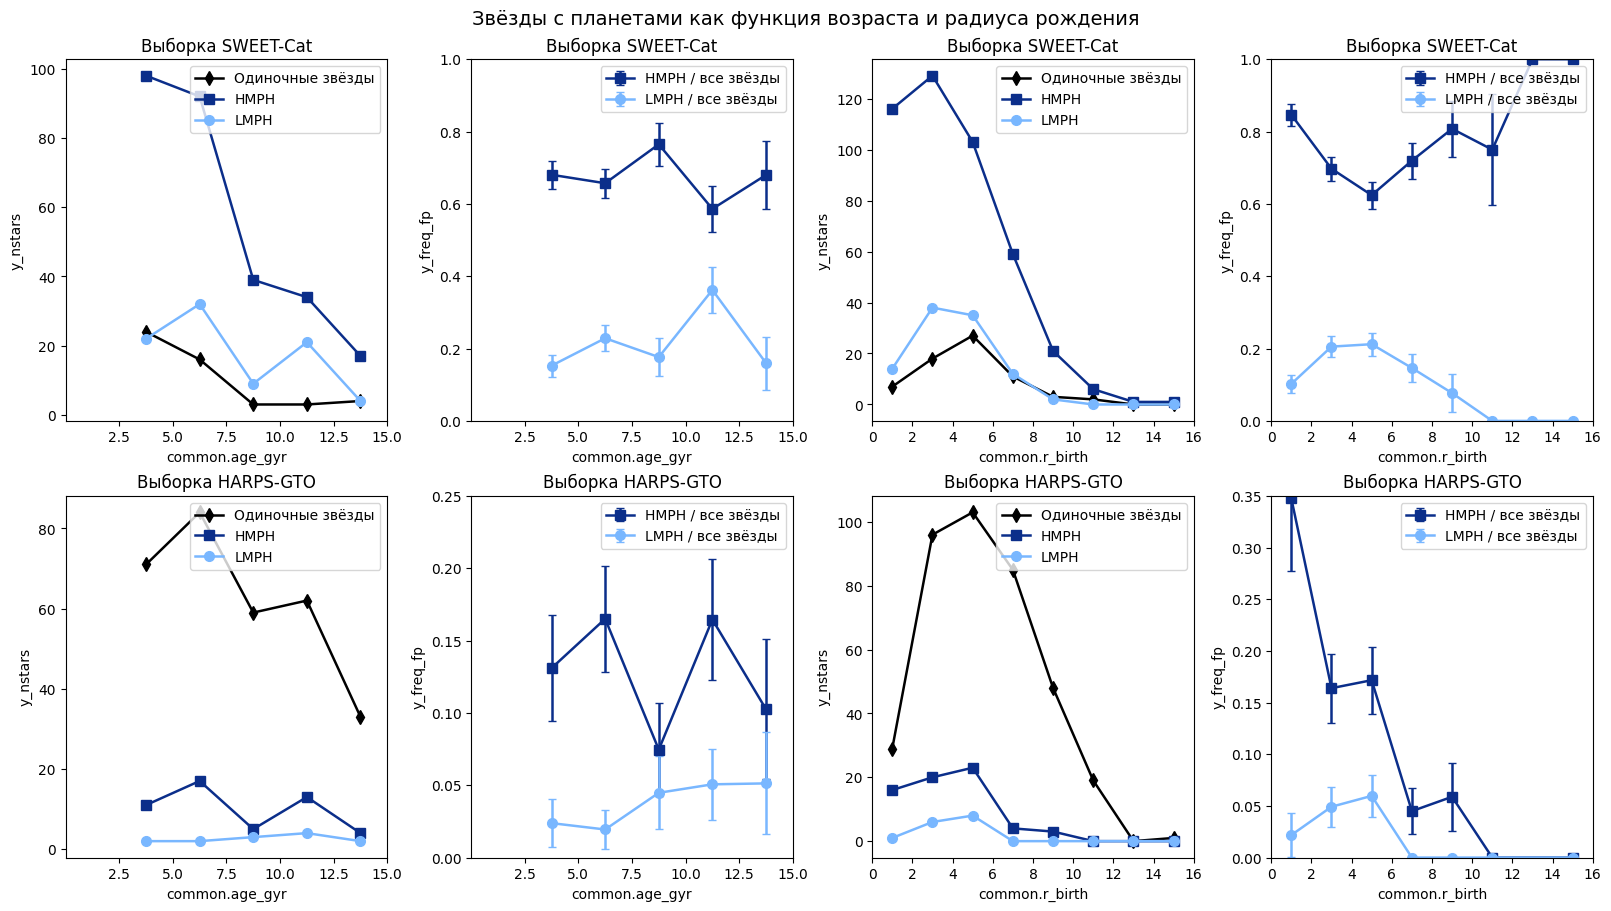

In [12]:
# =========================================================
# [ACAP_003|FIG_1] Figure 1 (i18n titles + i18n legend)
# Inputs:
#   - data/processed/sweetcat_rbirth_gce.csv
#   - data/processed/harps_rbirth_gce.csv
# Output:
#   - figure saved via save_fig0(...)
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sweet = pd.read_csv(DATA_PROCESSED_DIR / "sweetcat_rbirth_gce.csv")
harps = pd.read_csv(DATA_PROCESSED_DIR / "harps_rbirth_gce.csv")

sweet = sweet[np.isfinite(sweet["age_gyr"]) & np.isfinite(sweet["rbirth_kpc"])].copy()
harps = harps[np.isfinite(harps["age_gyr"]) & np.isfinite(harps["rbirth_kpc"])].copy()

# --- paper-like style (leave as-is for now)
COL = {"single": "k", "HMPH": "#0B2E8A", "LMPH": "#79B7FF"}
MRK = {"single": "d", "HMPH": "s", "LMPH": "o"}
LW, MS, CAP = 1.8, 7, 3

# i18n labels
LBL_SINGLE = L("legend_single")
LBL_HMPH   = L("legend_hmph")
LBL_LMPH   = L("legend_lmph")
LBL_H_FRAC = L("legend_hmph_frac")
LBL_L_FRAC = L("legend_lmph_frac")

Y_NSTARS = L("y_nstars")
Y_FP     = L("y_freq_fp")

X_AGE = L("common.age_gyr")
X_RB  = L("common.r_birth")

TITLE_FIG = T("figure_1")
TITLE_SWE = T("figure_1_sweet")
TITLE_HAR = T("figure_1_harps")

def counts_in_bins(df, xcol, bins, cls):
    x = df.loc[df["class"] == cls, xcol].dropna().to_numpy()
    return np.histogram(x, bins=bins)[0]

def frac_and_err(k, n):
    k = np.asarray(k, float)
    n = np.asarray(n, float)
    p = np.full_like(k, np.nan)
    err = np.full_like(k, np.nan)
    m = n > 0
    p[m] = k[m] / n[m]
    err[m] = np.sqrt(np.clip(p[m] * (1 - p[m]) / n[m], 0, None))
    return p, err

def plot_block(
    ax_counts, ax_freq, df, xcol, bins, xcent,
    xlabel, title, freq_ylim=(0, 1),
    mask_bins=None, xlim=None, xticks=None
):
    Ns = counts_in_bins(df, xcol, bins, "single")
    Nh = counts_in_bins(df, xcol, bins, "HMPH")
    Nl = counts_in_bins(df, xcol, bins, "LMPH")
    Nt = Ns + Nh + Nl

    if mask_bins is not None:
        Ns, Nh, Nl, Nt = Ns[mask_bins], Nh[mask_bins], Nl[mask_bins], Nt[mask_bins]
        xcent = xcent[mask_bins]

    # --- counts
    ax_counts.plot(xcent, Ns, marker=MRK["single"], ms=MS, lw=LW, color=COL["single"], label=LBL_SINGLE)
    ax_counts.plot(xcent, Nh, marker=MRK["HMPH"],   ms=MS, lw=LW, color=COL["HMPH"],   label=LBL_HMPH)
    ax_counts.plot(xcent, Nl, marker=MRK["LMPH"],   ms=MS, lw=LW, color=COL["LMPH"],   label=LBL_LMPH)

    ax_counts.set_title(title)
    ax_counts.set_xlabel(xlabel)
    ax_counts.set_ylabel(Y_NSTARS)
    ax_counts.legend(loc="upper right", frameon=True)

    # --- frequency
    ph, eh = frac_and_err(Nh, Nt)
    pl, el = frac_and_err(Nl, Nt)

    m = (Nt > 0) & np.isfinite(ph) & np.isfinite(eh)
    ax_freq.errorbar(
        xcent[m], ph[m], yerr=eh[m],
        marker=MRK["HMPH"], ms=MS, lw=LW, capsize=CAP,
        color=COL["HMPH"], label=LBL_H_FRAC
    )

    m = (Nt > 0) & np.isfinite(pl) & np.isfinite(el)
    ax_freq.errorbar(
        xcent[m], pl[m], yerr=el[m],
        marker=MRK["LMPH"], ms=MS, lw=LW, capsize=CAP,
        color=COL["LMPH"], label=LBL_L_FRAC
    )

    ax_freq.set_title(title)
    ax_freq.set_xlabel(xlabel)
    ax_freq.set_ylabel(Y_FP)
    ax_freq.set_ylim(*freq_ylim)
    ax_freq.legend(loc="upper right", frameon=True)

    if xlim is not None:
        ax_counts.set_xlim(*xlim)
        ax_freq.set_xlim(*xlim)
    if xticks is not None:
        ax_counts.set_xticks(xticks)
        ax_freq.set_xticks(xticks)

# =========================================================
# Re-clip rbirth to start at 0 (paper-like pile-up)
# =========================================================
sweet["rbirth_kpc"] = np.clip(sweet["rbirth_kpc"].to_numpy(float), 0.0, 20.0)
harps["rbirth_kpc"] = np.clip(harps["rbirth_kpc"].to_numpy(float), 0.0, 20.0)

# =========================================================
# Binning / ticks like paper
# =========================================================
age_bins = np.arange(0.0, 15.0 + 0.001, 2.5)
age_cent = 0.5 * (age_bins[:-1] + age_bins[1:])
mask_age = age_cent >= 2.5
age_ticks = age_bins[1:]
age_xlim = (0.0, 15.0)

r_bins = np.arange(0.0, 16.0 + 0.001, 2.0)
r_cent = 0.5 * (r_bins[:-1] + r_bins[1:])
r_ticks = np.arange(0, 17, 2)
r_xlim = (0.0, 16.0)

# =========================================================
# Combined Figure_1: 2 rows x 4 cols
# =========================================================
fig = plt.figure(figsize=(16, 9), constrained_layout=True)
gs = fig.add_gridspec(2, 4)

ax = {}
ax["s_age_cnt"] = fig.add_subplot(gs[0, 0]); ax["s_age_frq"] = fig.add_subplot(gs[0, 1])
ax["h_age_cnt"] = fig.add_subplot(gs[1, 0]); ax["h_age_frq"] = fig.add_subplot(gs[1, 1])
ax["s_r_cnt"]   = fig.add_subplot(gs[0, 2]); ax["s_r_frq"]   = fig.add_subplot(gs[0, 3])
ax["h_r_cnt"]   = fig.add_subplot(gs[1, 2]); ax["h_r_frq"]   = fig.add_subplot(gs[1, 3])

fig.suptitle(TITLE_FIG, fontsize=14)

# SWEET
plot_block(
    ax["s_age_cnt"], ax["s_age_frq"], sweet, "age_gyr",
    age_bins, age_cent, X_AGE, TITLE_SWE,
    freq_ylim=(0, 1), mask_bins=mask_age, xlim=age_xlim, xticks=age_ticks
)

plot_block(
    ax["s_r_cnt"], ax["s_r_frq"], sweet, "rbirth_kpc",
    r_bins, r_cent, X_RB, TITLE_SWE,
    freq_ylim=(0, 1), xlim=r_xlim, xticks=r_ticks
)

# HARPS
plot_block(
    ax["h_age_cnt"], ax["h_age_frq"], harps, "age_gyr",
    age_bins, age_cent, X_AGE, TITLE_HAR,
    freq_ylim=(0, 0.25), mask_bins=mask_age, xlim=age_xlim, xticks=age_ticks
)

plot_block(
    ax["h_r_cnt"], ax["h_r_frq"], harps, "rbirth_kpc",
    r_bins, r_cent, X_RB, TITLE_HAR,
    freq_ylim=(0, 0.35), xlim=r_xlim, xticks=r_ticks
)

save_fig0("Figure_1", fig=fig)
plt.show()

*Рисунок 1. Число звёзд и частота экзопланет в зависимости от возраста звезды и восстановленного галактоцентрического радиуса рождения (выборка SWEET-Cat)*

### Обзор рисунка

На этом рисунке показано, как частота планетных систем зависит от **возраста звёзд** и **восстановленного галактоцентрического радиуса рождения**, полученного на основе модельных оценок возрастов и мест формирования звёзд.

Верхний ряд соответствует выборке **SWEET-Cat**, нижний — независимой выборке **HARPS-GTO**. Для каждой выборки данные представлены в двух взаимодополняющих проекциях:

- **Левые панели (зависимость от возраста):**  
  Показаны число звёзд и относительная частота планетных хостов как функция возраста.  
  Хосты массивных планет (HMPH) преобладают среди молодых и промежуточных по возрасту звёзд, тогда как их доля заметно уменьшается в старых звёздных популяциях.

- **Правые панели (зависимость от радиуса рождения):**  
  Те же величины представлены как функция восстановленного галактоцентрического радиуса рождения.  
  Планетные хосты, особенно хосты массивных планет (HMPH), преимущественно связаны со звёздами, сформировавшимися во **внутреннем диске Галактики**, а их частота резко падает при увеличении радиуса рождения.

Качественные тенденции согласуются между обеими выборками:
- хосты массивных планет значительно чаще встречаются среди звёзд, сформированных на меньших галактоцентрических радиусах и в более ранние эпохи;
- хосты маломассивных планет (LMPH) демонстрируют более слабую, но всё же структурированную зависимость от возраста и радиуса рождения;
- согласие между результатами для SWEET-Cat и HARPS-GTO указывает на то, что выявленные тенденции не являются следствием особенностей одной конкретной выборки или эффектов селекции.

В целом, этот рисунок предоставляет убедительные наблюдательные свидетельства того, что **частота планет тесно связана с историей галактической химической эволюции и условиями формирования звёзд**, подчёркивая фундаментальную роль эволюции диска Млечного Пути в процессах планетообразования.

---

### Ячейка 12. Частота планетных хостов как функция радиуса рождения звёзд

#### Назначение этой ячейки

Эта ячейка строит **ключевой диагностический рисунок Практикума 3**, показывающий,
как частота звёзд с планетами зависит от **галактоцентрического радиуса рождения** звёзд
и как эта зависимость меняется с возрастом.

Рисунок по своей структуре и логике максимально близок к фигуре из опорной статьи
и представляет собой финальный синтез всех предыдущих этапов анализа.


#### Входные данные

Используются два финальных набора данных, сформированных ранее в ноутбуке:

- `sweetcat_rbirth_gce.csv`  
  Выборка **SWEET-Cat**, содержащая:
  - параметры звёзд,
  - возраста (по сетке MIST),
  - восстановленные радиусы рождения,
  - классификацию звёзд (single / LMPH / HMPH).

- `harps_rbirth_gce.csv`  
  Аналогичный набор данных для выборки **HARPS-GTO**.

В анализ включаются только звёзды с:
- конечными значениями возраста,
- конечными значениями радиуса рождения.


#### Что вычисляется

Для каждой выборки (SWEET-Cat и HARPS-GTO) анализ проводится в двух измерениях:

1. **Возрастные интервалы**
   Определяются три широкие группы:
   - старые звёзды (Age > 8 Gyr),
   - звёзды промежуточного возраста (4–8 Gyr),
   - молодые звёзды (Age < 4 Gyr).

2. **Бины по радиусу рождения**
   - Восстановленный радиус рождения `r_birth` бинируется в диапазоне 0–16 кпк.
   - Используется то же разбиение, что и в опорной статье, что облегчает визуальное сравнение.

В каждом бине подсчитываются:
- число одиночных звёзд,
- число хостов массивных планет (HMPH),
- число хостов маломассивных планет (LMPH),
- общее число звёзд.

Из этих величин вычисляются **относительные частоты** систем HMPH и LMPH.

Для оценки статистических неопределённостей используются **доверительные интервалы Вилсона**
(приблизительно 1σ), которые более устойчивы при малых числах объектов, чем простые
пуассоновские ошибки.


#### Что изображено на рисунке

Итоговый рисунок организован в виде **сетки 2 × 4 панелей**:

- **Строки**
  - верхняя строка: абсолютное число звёзд в каждом бине радиуса рождения,
  - нижняя строка: относительная частота планетных хостов.

- **Столбцы**
  - левая половина: выборка SWEET-Cat,
  - правая половина: выборка HARPS-GTO.

Для каждой выборки:
- левая пара панелей показывает зависимости от **возраста**,
- правая пара — зависимости от **радиуса рождения**.

Разные маркеры используются для различения:
- одиночных звёзд,
- систем HMPH,
- систем LMPH.


#### Научная роль этого рисунка

Этот рисунок напрямую отвечает на центральный вопрос Практикума 3:

> *Зависит ли вероятность формирования различных типов планетных систем от того,
> где и когда звёзды сформировались в диске Галактики?*

Объединяя:
- возраста звёзд,
- восстановленные радиусы рождения,
- классификацию планетных систем,

он предоставляет наблюдательные свидетельства существования **связи между
галактической химической эволюцией и эффективностью планетообразования**.

Этот шаг является логическим завершением всего аналитического пайплайна,
построенного в рамках данного практикума.

/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_57530/959097864.py:41: RuntimeWarning: invalid value encountered in divide
  p = np.where(n > 0, k / n, np.nan)
/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_57530/959097864.py:42: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 + (z**2) / n
/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_57530/959097864.py:43: RuntimeWarning: divide by zero encountered in divide
  center = (p + (z**2) / (2 * n)) / denom
/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_57530/959097864.py:44: RuntimeWarning: divide by zero encountered in divide
  half = (z * np.sqrt((p * (1 - p) + (z**2) / (4 * n)) / n)) / denom


Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/ru/ACAP_003_Figure_2.png


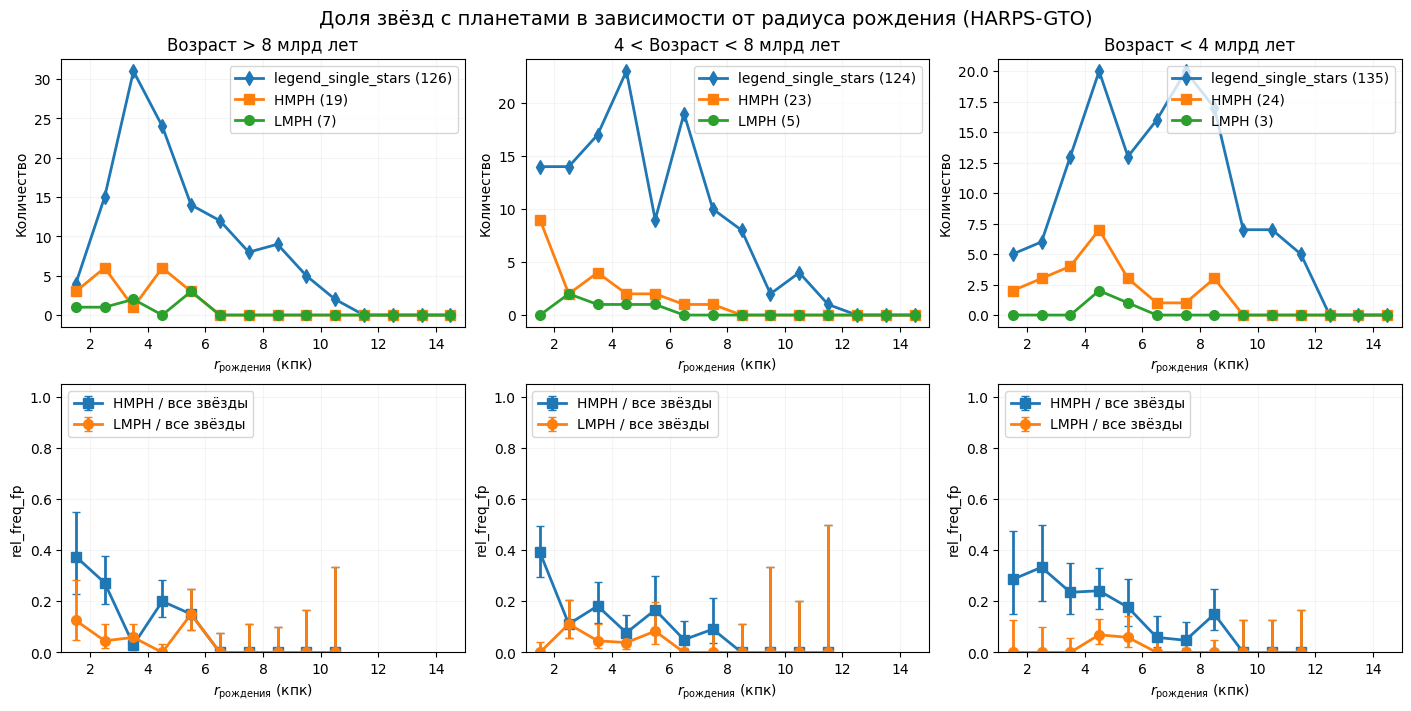

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================================
# [ACAP_003|FIGURE_2] HARPS: frequency of planet hosts vs r_birth in age bins
#
# Input:
#   - data/processed/harps_rbirth_gce.csv
# Output:
#   - Figure_2 (saved via save_fig0 -> ACAP_003_Figure_2.png)
# =========================================================

# --- load ---
csv_path = PROC / "harps_rbirth_gce.csv"
df = dfh.copy() if "dfh" in globals() else pd.read_csv(csv_path)

need = {"rbirth_kpc", "age_gyr", "class"}
miss = need - set(df.columns)
if miss:
    raise KeyError(f"Missing columns in HARPS table: {miss}")

df = df[np.isfinite(df["rbirth_kpc"]) & np.isfinite(df["age_gyr"])].copy()

# --- bins (paper-like) ---
age_bins = [(8.0, 13.5), (4.0, 8.0), (0.1, 4.0)]
age_titles = [T("age_bin_old"), T("age_bin_mid"), T("age_bin_young")]

rbins = np.arange(1.0, 16.0, 1.0)  # edges: 1..15
rcent = 0.5 * (rbins[:-1] + rbins[1:])

def hist_counts(sub: pd.DataFrame, cls: str) -> np.ndarray:
    x = sub.loc[sub["class"] == cls, "rbirth_kpc"].dropna().to_numpy()
    return np.histogram(x, bins=rbins)[0]

# --- Wilson score interval (binomial), 68% (~1σ) ---
def wilson_interval(k, n, z=1.0):
    k = np.asarray(k, dtype=float)
    n = np.asarray(n, dtype=float)

    p = np.where(n > 0, k / n, np.nan)
    denom = 1.0 + (z**2) / n
    center = (p + (z**2) / (2 * n)) / denom
    half = (z * np.sqrt((p * (1 - p) + (z**2) / (4 * n)) / n)) / denom

    lo = center - half
    hi = center + half
    return p, lo, hi

# --- labels (i18n) ---
X_RB = L("r_birth")                 # "$r_{\\rm birth}$ (kpc)" / "..."
Y_N  = L("count")                   # "Count" / "Количество"
Y_FP = L("rel_freq_fp")             # "Relative Frequency, $F_p$" / "..."

LEG_SINGLE = L("legend_single_stars")          # already exists in ACAP_001; reuse globally
LEG_HMPH   = L("legend_hmph")                  # add
LEG_LMPH   = L("legend_lmph")                  # add
LEG_H_FRAC = L("legend_hmph_frac")             # add
LEG_L_FRAC = L("legend_lmph_frac")             # add

TITLE = T("figure_2")                           # add

fig, axes = plt.subplots(2, 3, figsize=(14, 7), constrained_layout=True)
fig.suptitle(TITLE, fontsize=14)

for j, (a0, a1) in enumerate(age_bins):
    sub = df[(df["age_gyr"] >= a0) & (df["age_gyr"] < a1)].copy()

    Ns = hist_counts(sub, "single")
    Nh = hist_counts(sub, "HMPH")
    Nl = hist_counts(sub, "LMPH")
    Nt = Ns + Nh + Nl

    # ---------- Top: counts ----------
    ax = axes[0, j]
    ax.plot(rcent, Ns, marker="d", markersize=7, linewidth=2,
            label=f"{LEG_SINGLE} ({int((sub['class']=='single').sum())})")
    ax.plot(rcent, Nh, marker="s", markersize=7, linewidth=2,
            label=f"{LEG_HMPH} ({int((sub['class']=='HMPH').sum())})")
    ax.plot(rcent, Nl, marker="o", markersize=7, linewidth=2,
            label=f"{LEG_LMPH} ({int((sub['class']=='LMPH').sum())})")

    ax.set_title(age_titles[j])
    ax.set_xlabel(X_RB)
    ax.set_ylabel(Y_N)
    ax.set_xlim(rbins[0], rbins[-1])
    ax.grid(alpha=0.2)
    ax.legend(loc="upper right", frameon=True)

    # ---------- Bottom: fractions ----------
    ax = axes[1, j]

    ph, loh, hih = wilson_interval(Nh, Nt, z=1.0)
    pl, lol, hil = wilson_interval(Nl, Nt, z=1.0)

    eh_low, eh_high = ph - loh, hih - ph
    el_low, el_high = pl - lol, hil - pl

    ax.errorbar(
        rcent, ph,
        yerr=np.vstack([eh_low, eh_high]),
        marker="s", markersize=7, linewidth=2, capsize=3,
        label=LEG_H_FRAC
    )
    ax.errorbar(
        rcent, pl,
        yerr=np.vstack([el_low, el_high]),
        marker="o", markersize=7, linewidth=2, capsize=3,
        label=LEG_L_FRAC
    )

    ax.set_xlabel(X_RB)
    ax.set_ylabel(Y_FP)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(rbins[0], rbins[-1])
    ax.grid(alpha=0.2)
    ax.legend(loc="upper left", frameon=True)

save_fig0("Figure_2", fig=fig)
plt.show()

*Рисунок 2. Число звёзд и частота экзопланет как функция радиуса рождения, раздельно по возрастам. (данные HARPS)*

## Обзор рисунка

Этот рисунок показывает, как вероятность наличия планет зависит от
**галактоцентрического радиуса рождения** звёзд разных возрастов,
на основе радиусов рождения, восстановленных с помощью модели
галактической химической эволюции.

Выборка разделена на три возрастных интервала:
- **Возраст > 8 млрд лет** (левый столбец),
- **4 млрд лет < Возраст < 8 млрд лет** (средний столбец),
- **Возраст < 4 млрд лет** (правый столбец).

Для каждого возрастного интервала представлены два взаимодополняющих диагностических среза.

**Верхний ряд — Число звёзд**

- Показано количество одиночных звёзд, хостов массивных планет (HMPH) и хостов маломассивных планет (LMPH) как функция радиуса рождения.
- Во всех возрастных интервалах основная масса звёзд формировалась на галактоцентрических радиусах порядка нескольких килопарсек, что отражает общую структуру диска Галактики.
- Звёзды с планетами, особенно HMPH, заметно сконцентрированы к меньшим радиусам рождения.

**Нижний ряд — Относительная частота планет**

- Показана доля систем HMPH и LMPH относительно общего числа звёзд в каждом радиальном бине.
- Полосы ошибок соответствуют биномиальным статистическим неопределённостям.
- Для HMPH наблюдается систематически более высокая частота при малых радиусах рождения, особенно для молодых и звёзд промежуточного возраста.
- При больших радиусах рождения вероятность наличия планет быстро падает и становится совместимой с нулём в пределах ошибок.

Во всех возрастных интервалах проявляется одинаковое качественное поведение:
- формирование планет более эффективно во **внутреннем диске Галактики**, где металличность и эффективность звездообразования выше;
- выраженность радиальной зависимости ослабевает для старых звёзд, что согласуется с эффектами радиальной миграции и динамического перемешивания за время эволюции Галактики.

Этот рисунок наглядно демонстрирует, что объединение возрастов звёзд с восстановленными радиусами рождения позволяет выявить **временную эволюцию галактической среды планетообразования**.

Хотя качественные тенденции согласуются с результатами литературы [baba2023sunbirth], детальная форма распределений отличается из-за использования упрощённой модели GCE и независимой реконструкции возрастов.

## Итоговые выводы

В этом ноутбуке мы построили полный, основанный на наблюдениях рабочий процесс,
связывающий физические свойства звёзд с их галактической средой формирования,
с особым акцентом на звёзды — хосты планет.

Исходя из разнородных наблюдательных источников (HARPS, SWEET-Cat и NASA Exoplanet Archive),
мы собрали согласованный конвейер обработки данных, который:
- унифицирует параметры звёзд между различными каталогами,
- воспроизводимо классифицирует звёзды по наличию и типу планетных систем,
- определяет возраста звёзд с использованием физически мотивированных моделей звёздной эволюции,
- и восстанавливает галактоцентрические радиусы рождения на основе явной модели галактической химической эволюции.

Ключевой особенностью работы является чёткое разделение между исходными данными,
промежуточными продуктами и финальными визуализациями.
Все основные этапы преобразования сохраняются в виде промежуточных CSV-файлов,
что обеспечивает полную воспроизводимость анализа и позволяет легко проверять,
модифицировать или расширять его без повторных запросов к внешним сервисам.

Объединив возраста звёзд, их металличности и восстановленные радиусы рождения,
мы смогли исследовать, как звёзды с планетами распределяются в галактическом диске
как в пространстве, так и во времени.
Полученные диаграммы выявляют несколько устойчивых тенденций:
- хосты массивных и маломассивных планет занимают различные области в пространстве «возраст–радиус рождения»;
- относительная частота планетных систем зависит как от возраста звезды, так и от её предполагаемого радиуса рождения;
- эти зависимости согласуются со сценарием, в котором эффективность формирования планет определяется химической эволюцией галактического диска и дополнительно модифицируется радиальной миграцией звёзд.

Важно подчеркнуть и ограничения такого анализа.
Работа наглядно показывает, почему точное воспроизведение опубликованных фигур
в сложных, модельно-зависимых исследованиях часто невозможно.
Хотя восстановленные нами распределения могут отличаться в деталях от литературных,
они воспроизводят те же качественные закономерности и физические интерпретации.
Это подчёркивает ключевой принцип галактической археологии:
научные выводы основаны на устойчивых трендах, а не на пиксельно точном совпадении графиков.

В целом, данный ноутбук демонстрирует,
как современные исследования Галактики объединяют большие обзоры,
модели звёздной эволюции и упрощённые предписания химической эволюции
в прозрачную и воспроизводимую аналитическую схему.
Получившийся конвейер служит прочной основой для следующего этапа практикума,
где восстановленные радиусы рождения будут использованы
для проверки конкретных гипотез о формировании планет,
радиальной миграции и химической истории Млечного Пути.